In [1]:
import meshio
import numpy as np
import scipy.sparse as ss
from scipy.sparse.linalg import inv, spsolve
from scipy.linalg import block_diag

import section_properties as sec

# Test on single quadratic block (20 elements) 

Read mesh

In [2]:
case_folder = './test_01x01x01_hex20/'

In [3]:
S = sec.SectionProperties()
S.read_mesh(case_folder+'section_01x01x01_hex20clean.med','med')
S.get_interface_points()
S.mesh.point_tags
#S.get_modes(1)
S.load_matrices(case_folder+'Mass.npz', case_folder+'Stiff.npz')

In [4]:
S.mesh.point_tags

{2: ['R1'], 3: ['R2']}

Show numeric labels of mesh points

Show Tags of mesh points: **R1** and **R2** have been used to define the interface sections

## Compute Craig-Bampton

This step computes $K_{BB}$ and $M_{BB}$:

In _static equilibrium_ the following equation holds:

$$ F_r = K_{BB} \cdot U_r \label{eq:static} \tag{1}$$

In [5]:
S.compute_CB()

start computing Phi_r
Phi_r computed in 0.0022 seconds
compute M_BB
Step 1 0.0481 seconds
Step 2 0.0001 seconds
Step 3 0.0000 seconds
Step 4 0.0002 seconds
M_BB computed in 0.0485 seconds
K_BB computed in 0.0001 seconds


## Compute H matrices:

Reference points:
- $p_{0_1} $for section 1 (**R1**)
- $p_{0_2} $for section 2 (**R2**)

If only _rigid motion_ is allowed, the motion of the two faces can be traced back to the motion of the reference points:

$$U_r = H \cdot q_R \label{eqn:RBM} \tag{2}$$

with:

$$ q_R = \begin{Bmatrix} q_{R1} \\ q_{R2} \end{Bmatrix} $$

In [6]:
p01 = np.array([0.,0.,0.])
p02 = np.array([0.,0.,0.5])

l = 0.5
ea = np.array([0.0, 0.0, 1.0])

S.compute_RB_H_matrix(p01, p02)

## Compute C matrices:

When _section warping_ is added to the rigid motion of the sections, the motion of the points can be described as:

$$U_r = H \cdot q_R + C \cdot q_d \label{eqn:warp} \tag{3}$$

$C$ orthogonal to the rigid motion and computed as a **complete QR decomposition** of $H$.

The decomposition can be performed considering $H_1$ and $H_2$ separately, or $H = \begin{bmatrix} H_1 & 0 \\ 0 & H_2 \end{bmatrix}$

_Separated_

In [7]:
S.compute_C1C2()

QR computed in 0.0154 seconds
C computed in 0.0001 seconds


_Complete_

In [8]:
S.compute_Call()

QR (all) computed in 0.0014 seconds
C (all) computed in 0.0000 seconds


The estimation of $q_d$ can be done enforcing **minimum strain energy**, that is:

$$\mathcal{E} = \frac{1}{2} U_r^T \cdot K_{BB} \cdot U_r \label{eqn:energy} \tag{4}$$

substituting (3) into (4):

$$\mathcal{E} = \frac{1}{2} \left(H\cdot q_R + C \cdot q_d \right)^T \cdot K_{BB} \cdot \left(H\cdot q_R + C \cdot q_d \right)$$

because of symmetry:

$$\mathcal{E} = \frac{1}{2} q_R^T \cdot H^T \cdot K_{BB} \cdot H \cdot q_R  + \frac{1}{2} q_d^T \cdot C^T \cdot K_{BB} \cdot C \cdot q_d + q_R^T \cdot H^T \cdot K_{BB} \cdot C \cdot q_d$$

find $q_d$ s.t. $\mathcal{E}$ minimum:

$$\frac{\partial \mathcal{E}}{\partial q_d} = C^T \cdot K_{BB} \cdot C \cdot q_d + C^T \cdot K_{BB} \cdot H \cdot q_R = 0$$

solving for $q_d$:

$$q_d = -\left(C^T \cdot K_{BB} \cdot C \right)^{-1} \cdot C^T \cdot K_{BB} \cdot H \cdot q_R$$

so:

$$U_R = H \cdot q_R -C \cdot \left(C^T \cdot K_{BB} \cdot C \right)^{-1} \cdot C^T \cdot K_{BB} \cdot H \cdot q_R$$

and finally:

$$U_r = \left(H - H_{MSE}\right) \cdot q_R = \hat{H} \cdot q_R$$

Same results are obtained by equilibrium (see 2.39 in _modal-joint-from-numea_)


### From separated $H_i$ matrices

In [9]:
S.compute_MSE()

start computing MSE correction
V1 computed in 0.0005 seconds
V2 computed in 0.0011 seconds
K2 computed in 0.0011 seconds
V3 computed in 0.0083 seconds
MSE_H computed in 0.0000 seconds


### From complete $H$ matrix

In [10]:
S.compute_MSEall()

start computing MSE correction
V1 computed in 0.0003 seconds
V2 computed in 0.0004 seconds
K2 computed in 0.0003 seconds
V3 computed in 0.0005 seconds
MSE_H computed in 0.0000 seconds


## Test of the two different solutions:

given a vector

In [11]:
qR_test = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-3, 0.0, 0.0, 0.0])

In [12]:
S.compute_H_hat(S.MSE_H, 1.0)

In [13]:
qd_sep = S.H_hat @ qR_test

In [14]:
S.compute_H_hat(S.MSE_Hall, 1.0)

In [15]:
qd_all = S.H_hat @ qR_test

In [16]:
np.linalg.norm(qd_sep - qd_all)

1.1710699405165494e-18

## Resultants

from equilibrium considerations (or VWP as in 2.38) the 6 DoF resultants $f_R = \left(T_x T_y N_z M_x M_y M_z \right)$ on the two faces can be computed, from the nodal forces as

$$f_R = H^T \cdot F_r$$

Equation (1) can be turned into:

$$f_R = H^T \cdot K_{BB} \cdot \hat{H} \cdot q_R$$

i.e.:

$$f_R = K_r \cdot q_R$$

splitting into the 2 faces:

$$
\begin{Bmatrix} f_{R_1} \\ f_{R_2} \end{Bmatrix} = \begin{bmatrix} K_{r_{11}} & K_{r_{12}} \\ K_{r_{21}} & K_{r_{22}} \end{bmatrix} \cdot \begin{Bmatrix} q_{R_1} \\ q_{R_2} \end{Bmatrix}
$$

Imposing $q_{R_1} = 0$ and only axial force on *R2*:

$$q_{R_2} = K_{r_{22}}^{-1} \cdot f_{R_2}$$

and:

$$f_{R_1} = K_{r_{12}} \cdot q_{R_2}$$


Axial force on **R2**

In [17]:
fR2 = np.array([0.0, 0.0, 1e-4, 0.0, 0.0, 0.0])

### Compute $\hat{H}$ from $H_1$ and $H_2$

In [18]:
S.compute_H_hat(S.MSE_H, 1.0)
Kr = S.H.T * S.K_BB_d * S.H_hat
#Kr1 = S.H.T * S.K_BB_d * (S.H - S.Call * np.linalg.inv(S.Call.T * S.K_BB_d * S.Call) *S.Call.T * S.K_BB_d*S.H)

Find $q_{R_2}$:

In [19]:
qRB2 = np.linalg.solve(Kr[6:,6:], fR2)
qRB2

array([ 1.56648506e-17, -6.50742669e-18,  1.44105299e-03,  2.10379542e-17,
        4.64136208e-17,  3.22029826e-18])

Which is **not as expected** (it should be $10^{-3}$)

Find *reaction force* at **R1**

In [20]:
fR1 = Kr[:6,6:] @ qRB2
fR1

matrix([[-4.24970837e-20,  6.49955398e-20, -1.00000000e-04,
         -1.56239278e-20, -3.49975983e-20,  8.42818848e-22]])

Which is as expected.

We look at the nodal forces deriving from the solution:

$$U_r = \hat{H} \cdot q_R$$

and

$$F_r = K_{BB} \cdot R_r$$

we assemble $q_R$:

In [21]:
qRB = np.zeros((12,1))
qRB[6:] = qRB2.reshape((6,1))

In [22]:
UR = S.H_hat @ qRB

In [23]:
FR = S.K_BB_d * UR

### Nodal forces in z-direction

In [24]:
FR[2::3]

matrix([[-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05]])

### Nodal forces in x-direction

In [25]:
FR[::3]

matrix([[-1.35525272e-20],
        [-3.89635156e-20],
        [-1.69406589e-20],
        [-5.42101086e-20],
        [-6.77626358e-21],
        [ 3.38813179e-21],
        [ 1.69406589e-20],
        [ 5.08219768e-20],
        [ 0.00000000e+00],
        [-1.69406589e-20],
        [-6.77626358e-21],
        [-2.71050543e-20],
        [ 0.00000000e+00],
        [-6.77626358e-21],
        [ 2.71050543e-20],
        [ 4.40457133e-20]])

### Nodal forces in y-direction

In [26]:
FR[1::3]

matrix([[ 3.38813179e-21],
        [ 3.81164826e-21],
        [ 2.03287907e-20],
        [ 1.69406589e-21],
        [ 2.37169225e-20],
        [-6.77626358e-21],
        [-1.52465931e-20],
        [ 1.35525272e-20],
        [-1.69406589e-21],
        [-2.54109884e-20],
        [ 3.04931861e-20],
        [ 3.38813179e-21],
        [ 3.38813179e-21],
        [-2.37169225e-20],
        [-6.77626358e-21],
        [ 2.20228566e-20]])

### Compute $\hat{H}$ from $H$

In [27]:
S.compute_H_hat(S.MSE_Hall, 1.0)
Kr = S.H.T * S.K_BB_d * S.H_hat
#Kr1 = S.H.T * S.K_BB_d * (S.H - S.Call * np.linalg.inv(S.Call.T * S.K_BB_d * S.Call) *S.Call.T * S.K_BB_d*S.H)

In [28]:
qRB2 = np.linalg.solve(Kr[6:,6:], fR2)
qRB2

array([ 1.74502054e-17, -6.85287823e-18,  1.44105299e-03,  2.36676985e-17,
        5.27427509e-17,  2.88156218e-18])

In [29]:
UR = S.H_hat @ qRB
FR = S.K_BB_d * UR
FR[2::3]

matrix([[-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [-1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05],
        [ 1.25e-05]])

**same results as before**

In [30]:
S.compute_elastic_properties(l, ea)
S.D[2,2]

0.034696850379263955

## Reverse computation:

We start from an axial force $N_z = 10^{-4}$ and we compute the **expected** displacement or fhe *nodes* given the elastic and geometric properties

In [31]:
w = 0.2
h = 0.25
E = 1
ν = 0.25
G = E/(2*(1+ν))
A = w*h
l = 0.5

In [32]:
F = 0.0001

In [33]:
S.r1_set_point_ix

array([ 1,  3,  5,  7, 11, 15, 16, 18])

In [34]:
S.r2_set_point_ix

array([ 0,  2,  4,  6,  9, 13, 17, 19])

In [35]:
S.mesh.points

array([[-0.1  , -0.125,  0.5  ],
       [-0.1  , -0.125,  0.   ],
       [-0.1  ,  0.125,  0.5  ],
       [-0.1  ,  0.125,  0.   ],
       [ 0.1  , -0.125,  0.5  ],
       [ 0.1  , -0.125,  0.   ],
       [ 0.1  ,  0.125,  0.5  ],
       [ 0.1  ,  0.125,  0.   ],
       [-0.1  , -0.125,  0.25 ],
       [-0.1  ,  0.   ,  0.5  ],
       [-0.1  ,  0.125,  0.25 ],
       [-0.1  ,  0.   ,  0.   ],
       [ 0.1  , -0.125,  0.25 ],
       [ 0.1  ,  0.   ,  0.5  ],
       [ 0.1  ,  0.125,  0.25 ],
       [ 0.1  ,  0.   ,  0.   ],
       [ 0.   , -0.125,  0.   ],
       [ 0.   , -0.125,  0.5  ],
       [ 0.   ,  0.125,  0.   ],
       [ 0.   ,  0.125,  0.5  ]])

In [36]:
UR_comp = np.zeros((S.K_BB_d.shape[0],1))

for ind_point, curr_point in enumerate(S.r1_set_point_ix):
    for ind_coord in range(3):
        if ind_coord < 2:
            UR_comp[3*ind_point + ind_coord] = -ν/(E*A)*F*S.mesh.points[curr_point, ind_coord]
        else:
            UR_comp[3*ind_point + ind_coord] = 1/(E*A)*F*S.mesh.points[curr_point, ind_coord]

offset = len(S.r1_set_point_ix)            
            
for ind_point, curr_point in enumerate(S.r2_set_point_ix):
    for ind_coord in range(3):
        if ind_coord < 2:
            UR_comp[3*(offset + ind_point) + ind_coord] = -ν/(E*A)*F*S.mesh.points[curr_point, ind_coord]
        else:
            UR_comp[3*(offset + ind_point) + ind_coord] = 1/(E*A)*F*S.mesh.points[curr_point, ind_coord]

In [37]:
UR_comp

array([[ 5.00e-05],
       [ 6.25e-05],
       [ 0.00e+00],
       [ 5.00e-05],
       [-6.25e-05],
       [ 0.00e+00],
       [-5.00e-05],
       [ 6.25e-05],
       [ 0.00e+00],
       [-5.00e-05],
       [-6.25e-05],
       [ 0.00e+00],
       [ 5.00e-05],
       [-0.00e+00],
       [ 0.00e+00],
       [-5.00e-05],
       [-0.00e+00],
       [ 0.00e+00],
       [-0.00e+00],
       [ 6.25e-05],
       [ 0.00e+00],
       [-0.00e+00],
       [-6.25e-05],
       [ 0.00e+00],
       [ 5.00e-05],
       [ 6.25e-05],
       [ 1.00e-03],
       [ 5.00e-05],
       [-6.25e-05],
       [ 1.00e-03],
       [-5.00e-05],
       [ 6.25e-05],
       [ 1.00e-03],
       [-5.00e-05],
       [-6.25e-05],
       [ 1.00e-03],
       [ 5.00e-05],
       [-0.00e+00],
       [ 1.00e-03],
       [-5.00e-05],
       [-0.00e+00],
       [ 1.00e-03],
       [-0.00e+00],
       [ 6.25e-05],
       [ 1.00e-03],
       [-0.00e+00],
       [-6.25e-05],
       [ 1.00e-03]])

From the relationship $F_R = K_{BB} \cdot U_R$ we determine the nodal forces

In [38]:
FR_comp = S.K_BB_d * UR_comp

### Nodal forces in z-direction

In [39]:
FR_comp[2::3]

matrix([[ 8.33333333e-06],
        [ 8.33333333e-06],
        [ 8.33333333e-06],
        [ 8.33333333e-06],
        [-3.33333333e-05],
        [-3.33333333e-05],
        [-3.33333333e-05],
        [-3.33333333e-05],
        [-8.33333333e-06],
        [-8.33333333e-06],
        [-8.33333333e-06],
        [-8.33333333e-06],
        [ 3.33333333e-05],
        [ 3.33333333e-05],
        [ 3.33333333e-05],
        [ 3.33333333e-05]])

### Nodal forces in x-direction

In [40]:
FR_comp[::3]

matrix([[ 0.00000000e+00],
        [-1.35525272e-20],
        [ 5.92923063e-21],
        [ 0.00000000e+00],
        [ 1.01643954e-20],
        [ 1.22819777e-20],
        [-1.35525272e-20],
        [ 3.38813179e-21],
        [-1.35525272e-20],
        [-2.37169225e-20],
        [ 1.35525272e-20],
        [ 2.54109884e-21],
        [ 3.72694497e-20],
        [-5.75982404e-20],
        [-6.77626358e-21],
        [ 6.77626358e-21]])

### Nodal forces in y-direction

In [41]:
FR_comp[1::3]

matrix([[ 1.69406589e-20],
        [ 8.47032947e-22],
        [ 5.08219768e-21],
        [-5.92923063e-21],
        [-1.18584613e-20],
        [ 2.54109884e-21],
        [-2.37169225e-20],
        [ 3.55753838e-20],
        [ 1.43995601e-20],
        [-1.52465931e-20],
        [ 1.35525272e-20],
        [-2.20228566e-20],
        [ 8.47032947e-21],
        [ 1.35525272e-20],
        [-3.72694497e-20],
        [ 3.98105485e-20]])

We build the theoretical $q_R$ vector, which is composed of a single axial displacement (z) on **R2**. **R1** is supposed to be fixed 

In [42]:
qR_comp = np.zeros((12,1))
qR_comp[8] = 1e-3

Given the relationship in (3) we look for the *desired* $d_d$. The system is **overdetermined**:

In [43]:
qd, res, rank, sv = np.linalg.lstsq(S.C, UR_comp - S.H @ qR_comp, rcond=None)

In [44]:
qd

array([[-6.39462857e-05],
       [ 4.49646350e-05],
       [-2.86231607e-05],
       [-6.15475402e-05],
       [-8.00353650e-05],
       [-6.00194626e-05],
       [ 3.72530871e-05],
       [-1.56163686e-05],
       [ 1.94604362e-05],
       [-6.27469129e-05],
       [-1.75353650e-05],
       [-4.43213117e-05],
       [-1.39462857e-05],
       [ 4.59241332e-05],
       [ 3.26771326e-06],
       [-1.15475402e-05],
       [-7.90758668e-05],
       [-2.81285887e-05],
       [-6.39462857e-05],
       [ 4.49646350e-05],
       [-2.86231607e-05],
       [-6.15475402e-05],
       [-8.00353650e-05],
       [-6.00194626e-05],
       [ 3.72530871e-05],
       [-1.56163686e-05],
       [ 1.94604362e-05],
       [-6.27469129e-05],
       [-1.75353650e-05],
       [-4.43213117e-05],
       [-1.39462857e-05],
       [ 4.59241332e-05],
       [ 3.26771326e-06],
       [-1.15475402e-05],
       [-7.90758668e-05],
       [-2.81285887e-05]])

**Residual** of the computation

In [45]:
res

array([3.1771905e-38])

We build back the nodal displacements using the relationship:

$$H \cdot q_R + C \cdot q_d$$

In [46]:
UR_rev = S.H @ qR_comp + S.C @ qd
UR_rev

array([[ 5.00000000e-05],
       [ 6.25000000e-05],
       [-6.77626358e-21],
       [ 5.00000000e-05],
       [-6.25000000e-05],
       [ 6.77626358e-21],
       [-5.00000000e-05],
       [ 6.25000000e-05],
       [ 1.18584613e-20],
       [-5.00000000e-05],
       [-6.25000000e-05],
       [-6.77626358e-21],
       [ 5.00000000e-05],
       [-6.35274710e-21],
       [-1.35525272e-20],
       [-5.00000000e-05],
       [ 3.38813179e-20],
       [-3.38813179e-20],
       [ 1.69406589e-20],
       [ 6.25000000e-05],
       [ 2.20228566e-20],
       [-4.23516474e-20],
       [-6.25000000e-05],
       [ 3.38813179e-21],
       [ 5.00000000e-05],
       [ 6.25000000e-05],
       [ 1.00000000e-03],
       [ 5.00000000e-05],
       [-6.25000000e-05],
       [ 1.00000000e-03],
       [-5.00000000e-05],
       [ 6.25000000e-05],
       [ 1.00000000e-03],
       [-5.00000000e-05],
       [-6.25000000e-05],
       [ 1.00000000e-03],
       [ 5.00000000e-05],
       [-1.22819777e-20],
       [ 1.0

and the nodal forces

In [47]:
S.K_BB_d @ (S.H @ qR_comp + S.C @ qd)

matrix([[ 8.47032947e-21],
        [ 1.77876919e-20],
        [ 8.33333333e-06],
        [-5.92923063e-21],
        [ 6.98802181e-21],
        [ 8.33333333e-06],
        [ 1.52465931e-20],
        [-8.47032947e-22],
        [ 8.33333333e-06],
        [ 1.01643954e-20],
        [-8.47032947e-22],
        [ 8.33333333e-06],
        [ 1.65171425e-20],
        [-8.47032947e-21],
        [-3.33333333e-05],
        [ 3.38813179e-21],
        [ 6.77626358e-21],
        [-3.33333333e-05],
        [-2.37169225e-20],
        [-2.11758237e-20],
        [-3.33333333e-05],
        [-1.69406589e-20],
        [ 1.86347248e-20],
        [-3.33333333e-05],
        [-6.77626358e-21],
        [ 9.31736242e-21],
        [-8.33333333e-06],
        [-2.03287907e-20],
        [-1.18584613e-20],
        [-8.33333333e-06],
        [ 2.20228566e-20],
        [ 5.08219768e-21],
        [-8.33333333e-06],
        [ 1.10114283e-20],
        [-2.20228566e-20],
        [-8.33333333e-06],
        [ 4.06575815e-20],
 

## Current solution vs. desired solution

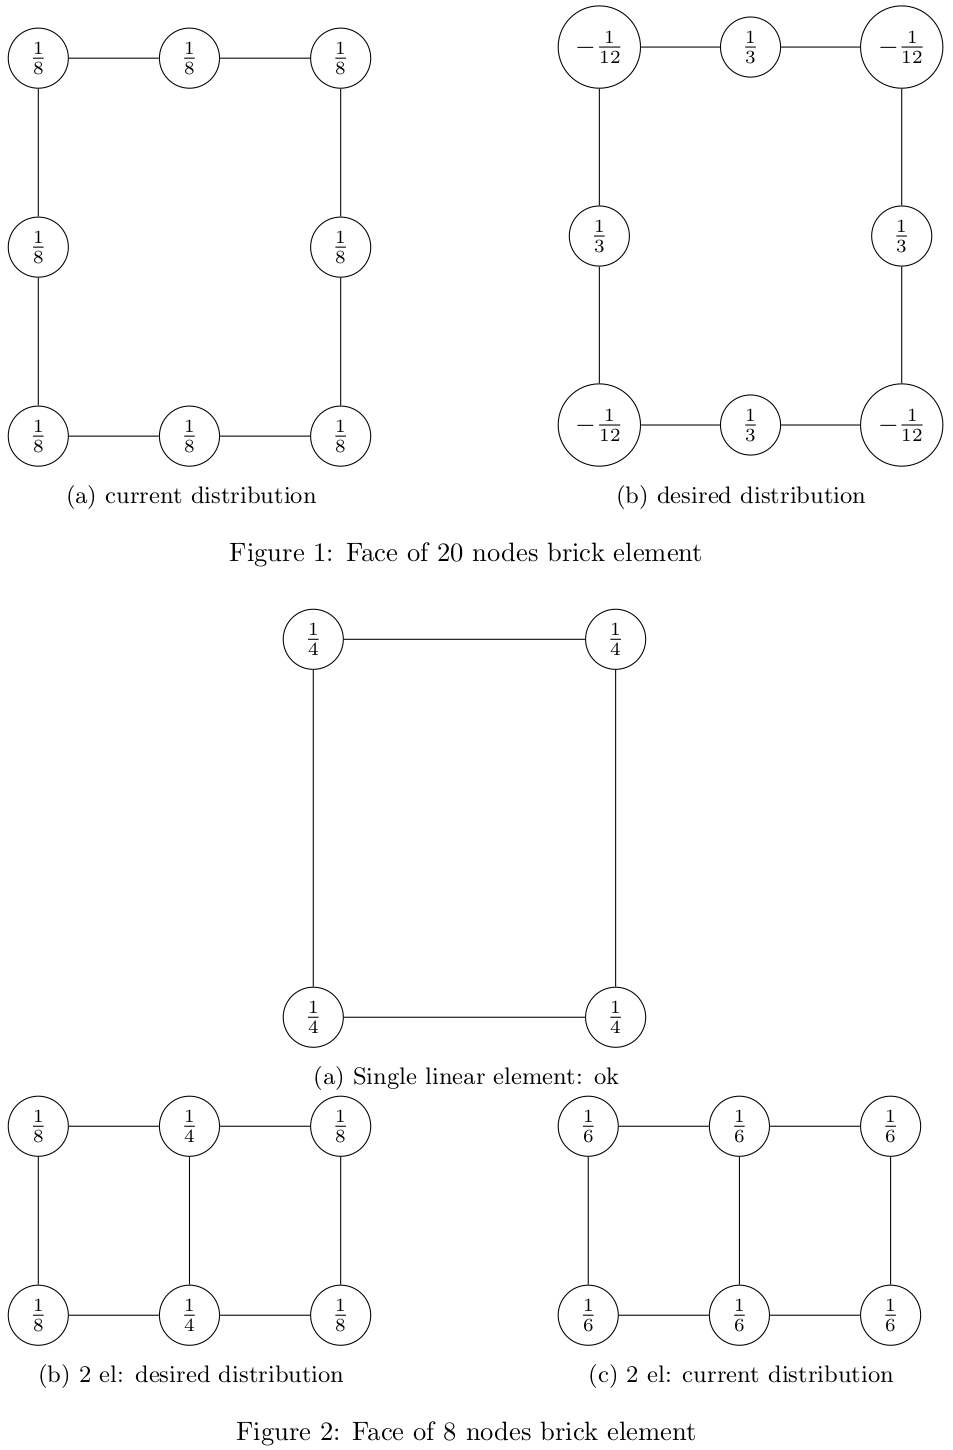

## Strain energy

**strain energy density**:
$$w = \frac{1}{2} \sigma_z \epsilon_z$$

Strain Energy:

$$\mathcal{E} = \frac{1}{2} \sigma_z \epsilon_z V = \frac{1}{2} \cdot \frac{F}{A} \cdot \frac{F}{EA} \cdot A \cdot l = \frac{1}{2}\cdot \frac{F^2l}{EA}$$

Strain Energy from FEM:

$$\mathcal{E} = \frac{1}{2} \cdot U_r^T \cdot K_{BB} \cdot U_r$$

In [48]:
E_th = 0.5* F**2*l/(E*A)
E_th

5e-08

In [49]:
E_CB = 0.5 * UR.T @ S.K_BB_d @ UR
E_CB

matrix([[7.20526495e-08]])

In [50]:
E_rev = 0.5 * UR_rev.T @ S.K_BB_d @ UR_rev
E_rev

matrix([[5.e-08]])

In [51]:
KBB_2 = S.K_BB_d
KBB_2[:6,:] = 0

In [52]:
H_MSE2 = S.C*np.linalg.inv(S.C.T @ S.K_BB_d @ S.C) @ S.C.T @KBB_2 @ S.H

In [53]:
S.compute_H_hat(H_MSE2)

In [54]:

S.compute_elastic_properties(l, ea)

In [55]:
S.D

matrix([[ 1.95569126e-01,  2.26522646e-02,  7.95168876e-03,
          9.12991402e-03,  2.80358665e-03,  2.22326007e-03],
        [-5.00151416e-02,  2.23688613e-02, -4.43616654e-04,
         -1.77467715e-03, -5.92810969e-04, -2.08975464e-04],
        [ 1.46759576e-02, -5.40447631e-03,  3.78921773e-02,
          9.25855302e-04,  2.17510056e-04,  1.97326927e-04],
        [ 7.04570846e-03,  1.24787930e-03,  6.76215013e-04,
          5.63553734e-04,  9.20591651e-05,  7.01864472e-05],
        [ 3.96680614e-03,  6.90604515e-04,  2.93826332e-04,
          2.19464634e-04,  2.15384702e-04,  5.65020077e-05],
        [ 1.12029204e-03,  4.50995167e-04,  1.81386823e-04,
          4.42518484e-05,  1.26319208e-05,  1.73548616e-04]])

In [56]:
S.D[2,2]

0.03789217728644133

In [57]:
E*A

0.05

In [58]:
F_Rnew = S.K_BB_d @ (S.H  - H_MSE2) @ qR_comp

In [59]:
F_Rnew[2::3]

matrix([[ 0.00000000e+00],
        [ 0.00000000e+00],
        [-8.21806303e-06],
        [-6.95480313e-06],
        [ 1.81470528e-05],
        [-8.95165236e-06],
        [-1.66830304e-05],
        [-1.51528628e-05],
        [ 6.23421068e-06],
        [ 5.32906849e-06],
        [ 9.12672904e-06],
        [ 7.92451003e-06],
        [ 2.08745458e-05],
        [ 1.14279606e-05],
        [ 2.13852516e-06],
        [ 6.89554451e-06]])

### Constrained minimization (full)

In [60]:
HC = np.zeros((S.H.shape[0], S.H.shape[1]+S.C.shape[1]))
HC[:,:S.H.shape[1]] = S.H
HC[:,S.H.shape[1]:] = S.C

In [61]:
E = S.H.T @ S.K_BB_d @ HC
Q = HC.T @ S.K_BB_d @ HC

In [62]:
A = np.zeros((Q.shape[0]+E.shape[0],Q.shape[1]+E.shape[0]))
A[:Q.shape[0],:Q.shape[0]] = Q
A[Q.shape[0]:,:E.shape[1]] = E
A[:E.shape[1],Q.shape[1]:] = E.T

b = np.zeros((A.shape[0],1))

In [63]:
b[-4] = F
b[-10] = -F

In [64]:
x = np.linalg.solve(A,b)

In [65]:
x

array([[ 3.68164507e+09],
       [-3.36698039e-02],
       [-1.88900979e+11],
       [ 1.01418376e+08],
       [ 6.33586073e+09],
       [ 1.78056062e+01],
       [ 6.84957543e+09],
       [-5.07091882e+07],
       [-1.88900979e+11],
       [ 1.01418376e+08],
       [ 6.33586073e+09],
       [ 1.78042556e+01],
       [ 5.68525241e-05],
       [-1.27129057e-03],
       [-6.10363862e-04],
       [ 8.13922199e-04],
       [-6.99792472e-04],
       [-1.53497942e-03],
       [ 5.20608163e-04],
       [-3.18060917e-04],
       [ 7.16721849e-04],
       [ 3.74513450e-04],
       [-1.01448803e-03],
       [-1.09762660e-03],
       [-2.13105314e-04],
       [-4.28503538e-04],
       [ 6.21763121e-05],
       [ 5.97065627e-04],
       [-7.48365341e-04],
       [-1.61859406e-04],
       [-1.08918422e-05],
       [-3.03819476e-04],
       [-1.02504333e-04],
       [-1.75070191e-05],
       [ 2.44672148e-04],
       [-2.17909277e-04],
       [-1.03872562e-04],
       [-5.48809577e-05],
       [ 2.9

In [67]:
0.5*x[:48].T * Q * x[:48]

matrix([[393216.]])

### Constrained minimization $q_{R1} = 0$

In [ ]:
HC.shape

In [ ]:
A1 = np.zeros((Q.shape[0]+E.shape[0]-12,Q.shape[1]+E.shape[0]-12))
A1[:Q.shape[0]-6,:Q.shape[0]-6] = Q[6:,6:]

A1[Q.shape[0]-6:,:E.shape[1]-6] = E[6:,6:]
A1[:E.shape[1]-6,Q.shape[1]-6:] = E[6:,6:].T

b1 = np.zeros((A1.shape[0],1))
b1[-4] = F

In [ ]:
x1 = np.linalg.solve(A1,b1)

In [ ]:
x1